# Classifying suicidality

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import re
from utility import clean_reddit_posts

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv("Suicidal Ideation Detection reddit Dataset.csv")

df

,Title,Post,Label
0,I'm looking for a girl I've met at the Polish ...,I've tried Polish spotted pages but I guess sh...,Non-Suicidal
1,I got a guy kicked off a domestic flight today.,I was in a forward row as we were boarding for...,Non-Suicidal
2,"My youngest got in school suspension, I’m so p...",So according to witness testimonies a boy grab...,Non-Suicidal
3,"I'm a cashier who switched from ""sir/mam"" to ""...","So as said in the title, I'm a cashier (well, ...",Non-Suicidal
4,My whole class complimented me and didn’t real...,"Today in class, we were doing this activity ca...",Non-Suicidal
...,...,...,...
15472,"Once I die, I can finally be at rest.","My past actions will no longer haunt me, hopef...",Suicidal
15473,I just want to stop.,I just want to stop living. I’ve lost everythi...,Suicidal
15474,I’m still alive,WHY THE FUCK AM I STILL ALIVE. WHY WONT I JUST...,Suicidal
15475,I'm lonely but I can't stand people,"It's a lot better online, but irl I can't stan...",Suicidal


For preference and ease of access, we also change the column names to lowercase.

In [3]:
df.columns = df.columns.str.lower()

In [4]:
df.head()

,title,post,label
0,I'm looking for a girl I've met at the Polish ...,I've tried Polish spotted pages but I guess sh...,Non-Suicidal
1,I got a guy kicked off a domestic flight today.,I was in a forward row as we were boarding for...,Non-Suicidal
2,"My youngest got in school suspension, I’m so p...",So according to witness testimonies a boy grab...,Non-Suicidal
3,"I'm a cashier who switched from ""sir/mam"" to ""...","So as said in the title, I'm a cashier (well, ...",Non-Suicidal
4,My whole class complimented me and didn’t real...,"Today in class, we were doing this activity ca...",Non-Suicidal


## Data Exploration and Cleaning

In [5]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 15477 entries, 0 to 15476
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   title   15477 non-null  str  
 1   post    14243 non-null  str  
 2   label   15477 non-null  str  
dtypes: str(3)
memory usage: 362.9 KB


There are some missing values for post

In [6]:
df.describe()

,title,post,label
count,15477,14243,15477
unique,15182,14230,3
top,Help,.,Non-Suicidal
freq,16,6,8201


There are some duplicates for title and post. There is also a mistake label.

### Looking into the Suicidality Label

In [7]:
df["label"].unique()

<StringArray>
['Non-Suicidal', 'Label', 'Suicidal']
Length: 3, dtype: str

The "Label" label appears to be an encoding error.

In [8]:
encoding_error = df[df["label"] == "Label"]
encoding_error

,title,post,label
7331,Captions,Posts,Label


This proves it to be an error, we remove this instance.

In [9]:
df = df.drop(index=encoding_error.index).reset_index(drop=True) # reset index for ease of access

In [10]:
df["label"].value_counts()

label
Non-Suicidal    8201
Suicidal        7275
Name: count, dtype: int64

In [11]:
label_count = df["label"].value_counts()

label_count

label
Non-Suicidal    8201
Suicidal        7275
Name: count, dtype: int64

Text(0.5, 0, 'Class')

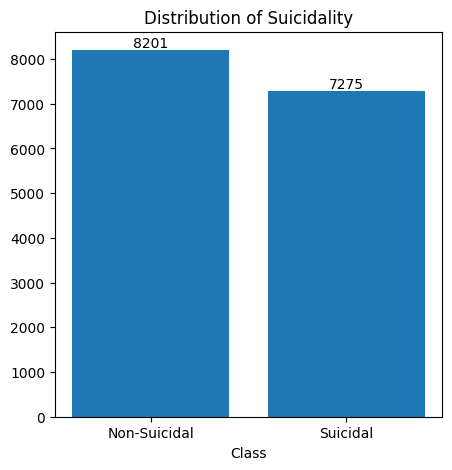

In [12]:
fig, ax = plt.subplots(figsize=[5,5])
bars = ax.bar(x=label_count.index, height=label_count)
ax.bar_label(bars)
ax.set_title("Distribution of Suicidality")
ax.set_xlabel("Class")

There is around 1000 instance difference between classes.

### Looking into the Post Feature
Earlier, we noticed that the post feature has a lot of missing values. Let us look into this feature.

In [13]:
missing_post = df[df["post"].isna()]

missing_post

,title,post,label
1007,Just a very important reminder for everyone to...,NaN,Non-Suicidal
1009,Does this count as a cat?,NaN,Non-Suicidal
1016,I bought a pumpkin for £20 and made it into a ...,NaN,Non-Suicidal
1097,Girlfriends grandmother is a great artist and ...,NaN,Non-Suicidal
1146,"My daughter's thrift store Joker costume, I th...",NaN,Non-Suicidal
...,...,...,...
15397,How to get over fear of death?,NaN,Suicidal
15413,I don't deserve to be alive im dumb haha,NaN,Suicidal
15416,Is anyone up to talk?,NaN,Suicidal
15451,I don't want to wait until I grow up. Why suff...,NaN,Suicidal


In [14]:
missing_post.value_counts(subset="label")

label
Non-Suicidal    765
Suicidal        469
Name: count, dtype: int64

Among the instances with missing posts, more of them are non-suicidal posts. In order to retain as much information as possible, we will deal with the missing values accordingly.

In [15]:
# Track which instance has missing posts
df["has_post"] = (~df["post"].isna()).astype(int) # Modeling purpose, having no post might be informational in the classification.

In [16]:
# Fill missing post with empty string
df["post"] = df["post"].fillna("")

In [17]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 15476 entries, 0 to 15475
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   title     15476 non-null  str  
 1   post      15476 non-null  str  
 2   label     15476 non-null  str  
 3   has_post  15476 non-null  int64
dtypes: int64(1), str(3)
memory usage: 483.8 KB


### Looking into the duplicates
Earlier we noticed duplicate values in the title and post features, we validate their correctness.

To easily view the text as a whole, we make another feature combining both the title and the post.

In [18]:
df["text"] = df["title"] + " " + df["post"]

df.head()

,title,post,label,has_post,text
0,I'm looking for a girl I've met at the Polish ...,I've tried Polish spotted pages but I guess sh...,Non-Suicidal,1,I'm looking for a girl I've met at the Polish ...
1,I got a guy kicked off a domestic flight today.,I was in a forward row as we were boarding for...,Non-Suicidal,1,I got a guy kicked off a domestic flight today...
2,"My youngest got in school suspension, I’m so p...",So according to witness testimonies a boy grab...,Non-Suicidal,1,"My youngest got in school suspension, I’m so p..."
3,"I'm a cashier who switched from ""sir/mam"" to ""...","So as said in the title, I'm a cashier (well, ...",Non-Suicidal,1,"I'm a cashier who switched from ""sir/mam"" to ""..."
4,My whole class complimented me and didn’t real...,"Today in class, we were doing this activity ca...",Non-Suicidal,1,My whole class complimented me and didn’t real...


In [19]:
duplicated_values = df[df["text"].duplicated()] # text is the combined title and post
duplicated_values

,title,post,label,has_post,text


With this we see that there are no duplicated values as a whole.

To further validate, we get a duplicated title and view its duplicates.

In [20]:
duplicated_title_test = df[df["title"].duplicated()]["title"].iloc[0]
duplicated_title_test

'I quit my job today.'

In [21]:
df[df["title"] == duplicated_title_test]

,title,post,label,has_post,text
188,I quit my job today.,I work for an agency and they've sent me to so...,Non-Suicidal,1,I quit my job today. I work for an agency and ...
495,I quit my job today.,I quit my job today. Only lasted 4 months. But...,Non-Suicidal,1,I quit my job today. I quit my job today. Only...


We see that even if the title is the same, they are two different posts.

We do the same for post

In [22]:
duplicated_post_test = df[df["post"].duplicated() & (df["post"] != "")]["post"].iloc[0]
duplicated_post_test

'.'

We look into these period posts.

In [23]:
df[df["post"] == duplicated_post_test]

,title,post,label,has_post,text
1929,I wish I didn't have to age.,.,Non-Suicidal,1,I wish I didn't have to age. .
8971,"I am supposed to be treated and I was happy,so...",.,Suicidal,1,"I am supposed to be treated and I was happy,so..."
10409,Hanging myself tonight so I avoid my birthday ...,.,Suicidal,1,Hanging myself tonight so I avoid my birthday ...
12441,Just mixed Alprazolam with the Alchohol,.,Suicidal,1,Just mixed Alprazolam with the Alchohol .
14324,I noticed that I was on a downward spiral back...,.,Suicidal,1,I noticed that I was on a downward spiral back...
15288,Why do good people die early,.,Suicidal,1,Why do good people die early .


There are some posters who put their message on the title and leave the post blank.

### Looking into the Text Feature

In [24]:
# Text with all uppercase 
def uppercase_count(text):
    words = text.split()
    count = sum([1 for word in words if word.isupper() and len(word) > 1])
    ratio = 0
    if len(text) > 0:
        ratio = count / len(words)
    return count, ratio


In [25]:
df["uppercase_count"], df["uppercase_ratio"] = zip(*df["text"].apply(uppercase_count))

df

,title,post,label,has_post,text,uppercase_count,uppercase_ratio
0,I'm looking for a girl I've met at the Polish ...,I've tried Polish spotted pages but I guess sh...,Non-Suicidal,1,I'm looking for a girl I've met at the Polish ...,4,0.017391
1,I got a guy kicked off a domestic flight today.,I was in a forward row as we were boarding for...,Non-Suicidal,1,I got a guy kicked off a domestic flight today...,1,0.004950
2,"My youngest got in school suspension, I’m so p...",So according to witness testimonies a boy grab...,Non-Suicidal,1,"My youngest got in school suspension, I’m so p...",4,0.050000
3,"I'm a cashier who switched from ""sir/mam"" to ""...","So as said in the title, I'm a cashier (well, ...",Non-Suicidal,1,"I'm a cashier who switched from ""sir/mam"" to ""...",0,0.000000
4,My whole class complimented me and didn’t real...,"Today in class, we were doing this activity ca...",Non-Suicidal,1,My whole class complimented me and didn’t real...,1,0.005435
...,...,...,...,...,...,...,...
15471,"Once I die, I can finally be at rest.","My past actions will no longer haunt me, hopef...",Suicidal,1,"Once I die, I can finally be at rest. My past ...",0,0.000000
15472,I just want to stop.,I just want to stop living. I’ve lost everythi...,Suicidal,1,I just want to stop. I just want to stop livin...,0,0.000000
15473,I’m still alive,WHY THE FUCK AM I STILL ALIVE. WHY WONT I JUST...,Suicidal,1,I’m still alive WHY THE FUCK AM I STILL ALIVE....,17,0.140496
15474,I'm lonely but I can't stand people,"It's a lot better online, but irl I can't stan...",Suicidal,1,I'm lonely but I can't stand people It's a lot...,0,0.000000


In [26]:
uppercase_per_label = df.groupby("label").agg({"uppercase_count": "sum", "uppercase_ratio": "mean"})

uppercase_per_label

,uppercase_count,uppercase_ratio
label,,
Non-Suicidal,6953,0.008862
Suicidal,8155,0.008668


Text(0.5, 0.98, 'Uppercase_count and Ratio per Label')

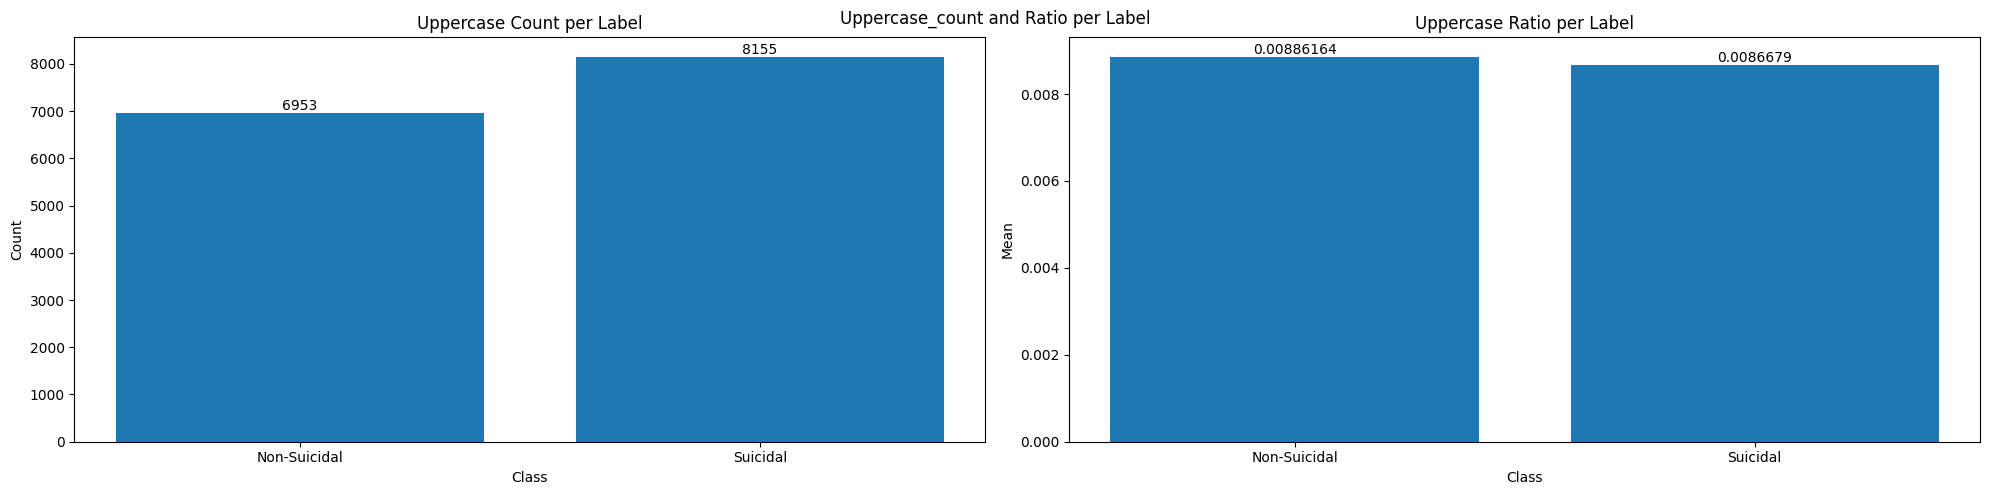

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

count_bars = ax[0].bar(x=uppercase_per_label["uppercase_count"].index, height=uppercase_per_label["uppercase_count"])
ax[0].bar_label(count_bars)
ax[0].set_title("Uppercase Count per Label")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Count")

ratio_bars = ax[1].bar(x=uppercase_per_label["uppercase_ratio"].index, height=uppercase_per_label["uppercase_ratio"])
ax[1].bar_label(ratio_bars)
ax[1].set_title("Uppercase Ratio per Label")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Mean")

fig.tight_layout()
fig.suptitle("Uppercase_count and Ratio per Label")

Non-suicidal posts have less uppercase word counts, although their word ratio are similar on average.  We keep those elements since they matter in conveying emotion. However, since it may cause overhead for traditional ml models, we will create a separate column with the text all lowercase, but we will retain the counts and ratios for reference. For deeper models like neural networks, we retain them.

In [38]:
# Has links
def has_links(text):
    pattern = r"https?://\S+|www\.\S+"

    return True if re.search(pattern, text) else False

In [39]:
has_links_bool = df["text"].map(has_links)

has_links_bool.sum()

np.int64(198)

In [40]:
df[has_links_bool]

,title,post,label,has_post,text,uppercase_count,uppercase_ratio,text_cleaned,text_traditional
37,I created a playlist of 1.868 songs that vario...,I made a playlist of 1.868 songs that differen...,Non-Suicidal,1,I created a playlist of 1.868 songs that vario...,2,0.015038,I created a playlist of 1.868 songs that vario...,i created a playlist of 1.868 songs that vario...
58,Gave my friend a bouquet for her birthday and ...,Her name’s actually a flower and so I thought ...,Non-Suicidal,1,Gave my friend a bouquet for her birthday and ...,0,0.000000,Gave my friend a bouquet for her birthday and ...,gave my friend a bouquet for her birthday and ...
81,My old man dog sometimes makes me sad.,I adopted an old dog from the shelter about 10...,Non-Suicidal,1,My old man dog sometimes makes me sad. I adopt...,0,0.000000,My old man dog sometimes makes me sad. I adopt...,my old man dog sometimes makes me sad. i adopt...
91,I'm 37 years old and going to see the ocean fo...,Heres the updated post! [Update!](https://www....,Non-Suicidal,1,I'm 37 years old and going to see the ocean fo...,0,0.000000,I'm 37 years old and going to see the ocean fo...,i'm 37 years old and going to see the ocean fo...
93,I'm 37 years old and finally got to see the oc...,This is an update post for:\n\n[I'm 37 years o...,Non-Suicidal,1,I'm 37 years old and finally got to see the oc...,45,0.016146,I'm 37 years old and finally got to see the oc...,i'm 37 years old and finally got to see the oc...
...,...,...,...,...,...,...,...,...,...
10237,My sister told me to kill myself (part 2),Part 1 (Read first): [https://www.reddit.com/r...,Suicidal,1,My sister told me to kill myself (part 2) Part...,0,0.000000,My sister told me to kill myself (part 2) Part...,my sister told me to kill myself (part 2) part...
10515,Few more days and i'm checking out,Bit over 7grams of snri antidepressants and ha...,Suicidal,1,Few more days and i'm checking out Bit over 7g...,3,0.026316,Few more days and i'm checking out Bit over 7g...,few more days and i'm checking out bit over 7g...
11151,"Found out from my new therapist, that my old t...",Last time I updated on this:\n\nhttps://www.re...,Suicidal,1,"Found out from my new therapist, that my old t...",1,0.002899,"Found out from my new therapist, that my old t...","found out from my new therapist, that my old t..."
13138,i miss my dead friends and want to join them,https://www.reddit.com/r/SuicideWatch/comments...,Suicidal,1,i miss my dead friends and want to join them h...,1,0.005000,i miss my dead friends and want to join them <...,i miss my dead friends and want to join them <...


There are some instances with links in their values. We replace these links with a \<URL> tag in the preprocessing stage, for now we leave them be.

We also notice that some of the posts have escape characters, we first inspect them to understand how to deal with them.

In [41]:
# Has escape characters
def has_escape(text):
    pattern = r"\\."

    return True if re.search(pattern, text) else False    

In [42]:
has_escape_bool = df["text"].map(has_escape)

df[has_escape_bool]

,title,post,label,has_post,text,uppercase_count,uppercase_ratio,text_cleaned,text_traditional
31,All the things my GF's dad does,"So I'm 18M, have been with my gf(also 18) for ...",Non-Suicidal,1,"All the things my GF's dad does So I'm 18M, ha...",3,0.009288,"All the things my GF's dad does So I'm 18M, ha...","all the things my gf's dad does so i'm 18m, ha..."
123,The reddit blackout just showed me how addicte...,"\*opens Reddit\*\n\n""Oh, right, the blackout, ...",Non-Suicidal,1,The reddit blackout just showed me how addicte...,0,0.000000,The reddit blackout just showed me how addicte...,the reddit blackout just showed me how addicte...
125,Never meet your heroes :|,"I'm pretty into weightlifting, and my boyfrien...",Non-Suicidal,1,Never meet your heroes :| I'm pretty into weig...,0,0.000000,Never meet your heroes :| I'm pretty into weig...,never meet your heroes :| i'm pretty into weig...
276,I've been unknowingly making naan bread for ye...,You know when you've been doing something you ...,Non-Suicidal,1,I've been unknowingly making naan bread for ye...,0,0.000000,I've been unknowingly making naan bread for ye...,i've been unknowingly making naan bread for ye...
572,Why do some people eat the same food every day...,I work with a guy that makes PB and J for lunc...,Non-Suicidal,1,Why do some people eat the same food every day...,1,0.006173,Why do some people eat the same food every day...,why do some people eat the same food every day...
...,...,...,...,...,...,...,...,...,...
14622,Less than bread,so I was talking to some friend of mine.\nturn...,Suicidal,1,Less than bread so I was talking to some frien...,0,0.000000,Less than bread so I was talking to some frien...,less than bread so i was talking to some frien...
14694,Letter for Nobody,"Dear Nobody in Particular, I've been alone thi...",Suicidal,1,"Letter for Nobody Dear Nobody in Particular, I...",2,0.002283,"Letter for Nobody Dear Nobody in Particular, I...","letter for nobody dear nobody in particular, i..."
15080,32 years of Complex PTSD caused by abuse from ...,I'm tired of the platitudes from the health pr...,Suicidal,1,32 years of Complex PTSD caused by abuse from ...,4,0.017391,32 years of Complex PTSD caused by abuse from ...,32 years of complex ptsd caused by abuse from ...
15222,Postponing for the Holidays,Anyone deeply “want out” but are postponing to...,Suicidal,1,Postponing for the Holidays Anyone deeply “wan...,0,0.000000,Postponing for the Holidays Anyone deeply “wan...,postponing for the holidays anyone deeply “wan...


We see that some of the stylistic text like `*opens Reddit*` are also being used. We will retain those as they add to the context, while the newlines will be replaced by spaces.

Given what we have seen, we will make a unified clean_reddit_post function and put it in new column.

In [43]:
df["text_cleaned"] = df["text"].apply(clean_reddit_posts)

In [44]:
df

,title,post,label,has_post,text,uppercase_count,uppercase_ratio,text_cleaned,text_traditional
0,I'm looking for a girl I've met at the Polish ...,I've tried Polish spotted pages but I guess sh...,Non-Suicidal,1,I'm looking for a girl I've met at the Polish ...,4,0.017391,I'm looking for a girl I've met at the Polish ...,i'm looking for a girl i've met at the polish ...
1,I got a guy kicked off a domestic flight today.,I was in a forward row as we were boarding for...,Non-Suicidal,1,I got a guy kicked off a domestic flight today...,1,0.004950,I got a guy kicked off a domestic flight today...,i got a guy kicked off a domestic flight today...
2,"My youngest got in school suspension, I’m so p...",So according to witness testimonies a boy grab...,Non-Suicidal,1,"My youngest got in school suspension, I’m so p...",4,0.050000,"My youngest got in school suspension, I’m so p...","my youngest got in school suspension, i’m so p..."
3,"I'm a cashier who switched from ""sir/mam"" to ""...","So as said in the title, I'm a cashier (well, ...",Non-Suicidal,1,"I'm a cashier who switched from ""sir/mam"" to ""...",0,0.000000,"I'm a cashier who switched from ""sir/mam"" to ""...","i'm a cashier who switched from ""sir/mam"" to ""..."
4,My whole class complimented me and didn’t real...,"Today in class, we were doing this activity ca...",Non-Suicidal,1,My whole class complimented me and didn’t real...,1,0.005435,My whole class complimented me and didn’t real...,my whole class complimented me and didn’t real...
...,...,...,...,...,...,...,...,...,...
15471,"Once I die, I can finally be at rest.","My past actions will no longer haunt me, hopef...",Suicidal,1,"Once I die, I can finally be at rest. My past ...",0,0.000000,"Once I die, I can finally be at rest. My past ...","once i die, i can finally be at rest. my past ..."
15472,I just want to stop.,I just want to stop living. I’ve lost everythi...,Suicidal,1,I just want to stop. I just want to stop livin...,0,0.000000,I just want to stop. I just want to stop livin...,i just want to stop. i just want to stop livin...
15473,I’m still alive,WHY THE FUCK AM I STILL ALIVE. WHY WONT I JUST...,Suicidal,1,I’m still alive WHY THE FUCK AM I STILL ALIVE....,17,0.140496,I’m still alive WHY THE FUCK AM I STILL ALIVE....,i’m still alive why the fuck am i still alive....
15474,I'm lonely but I can't stand people,"It's a lot better online, but irl I can't stan...",Suicidal,1,I'm lonely but I can't stand people It's a lot...,0,0.000000,I'm lonely but I can't stand people It's a lot...,i'm lonely but i can't stand people it's a lot...


As mentioned earlier with the uppercase, we lowercase everything for traditional ml algorithms

In [35]:
df["text_traditional"] = df["text_cleaned"].str.lower()

df

,title,post,label,has_post,text,uppercase_count,uppercase_ratio,text_cleaned,text_traditional
0,I'm looking for a girl I've met at the Polish ...,I've tried Polish spotted pages but I guess sh...,Non-Suicidal,1,I'm looking for a girl I've met at the Polish ...,4,0.017391,I'm looking for a girl I've met at the Polish ...,i'm looking for a girl i've met at the polish ...
1,I got a guy kicked off a domestic flight today.,I was in a forward row as we were boarding for...,Non-Suicidal,1,I got a guy kicked off a domestic flight today...,1,0.004950,I got a guy kicked off a domestic flight today...,i got a guy kicked off a domestic flight today...
2,"My youngest got in school suspension, I’m so p...",So according to witness testimonies a boy grab...,Non-Suicidal,1,"My youngest got in school suspension, I’m so p...",4,0.050000,"My youngest got in school suspension, I’m so p...","my youngest got in school suspension, i’m so p..."
3,"I'm a cashier who switched from ""sir/mam"" to ""...","So as said in the title, I'm a cashier (well, ...",Non-Suicidal,1,"I'm a cashier who switched from ""sir/mam"" to ""...",0,0.000000,"I'm a cashier who switched from ""sir/mam"" to ""...","i'm a cashier who switched from ""sir/mam"" to ""..."
4,My whole class complimented me and didn’t real...,"Today in class, we were doing this activity ca...",Non-Suicidal,1,My whole class complimented me and didn’t real...,1,0.005435,My whole class complimented me and didn’t real...,my whole class complimented me and didn’t real...
...,...,...,...,...,...,...,...,...,...
15471,"Once I die, I can finally be at rest.","My past actions will no longer haunt me, hopef...",Suicidal,1,"Once I die, I can finally be at rest. My past ...",0,0.000000,"Once I die, I can finally be at rest. My past ...","once i die, i can finally be at rest. my past ..."
15472,I just want to stop.,I just want to stop living. I’ve lost everythi...,Suicidal,1,I just want to stop. I just want to stop livin...,0,0.000000,I just want to stop. I just want to stop livin...,i just want to stop. i just want to stop livin...
15473,I’m still alive,WHY THE FUCK AM I STILL ALIVE. WHY WONT I JUST...,Suicidal,1,I’m still alive WHY THE FUCK AM I STILL ALIVE....,17,0.140496,I’m still alive WHY THE FUCK AM I STILL ALIVE....,i’m still alive why the fuck am i still alive....
15474,I'm lonely but I can't stand people,"It's a lot better online, but irl I can't stan...",Suicidal,1,I'm lonely but I can't stand people It's a lot...,0,0.000000,I'm lonely but I can't stand people It's a lot...,i'm lonely but i can't stand people it's a lot...


In [ ]:
# Checking quality of cleaning
has_links_bool = df["text_cleaned"].apply(has_links)
has_escape_bool = df["text_cleaned"].apply(has_escape)

print(f"Instances with links: {has_links_bool.sum()}")
print(f"Instances with escape characters: {has_escape_bool.sum()}")

Instances with links 0
Instances with escape characters 0


## Feature Engineering
To aid traditional machine learning models, we engineer more features from the text. The uppercase counts is an example of this.